# Predicting Stock Prices
CO542 Project

In [28]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

## 1. Data preprocessing <a class="anchor" id="chapter1"></a>
### a. Upload and plot data <a class="anchor" id="section_1_1"></a>

In [29]:
import yfinance as yf

# Define the stock ticker and time period
ticker = "TSLA"
start_date = "2010-01-01"  # Adjust as needed
end_date = "2025-01-01"    # Adjust as needed

# Download historical data
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Save data to a CSV file
stock_data.to_csv("tesla_stock_data.csv")

# Display the first few rows
print(stock_data.head())


[*********************100%***********************]  1 of 1 completed

Price          Close      High       Low      Open     Volume
Ticker          TSLA      TSLA      TSLA      TSLA       TSLA
Date                                                         
2010-06-29  1.592667  1.666667  1.169333  1.266667  281494500
2010-06-30  1.588667  2.028000  1.553333  1.719333  257806500
2010-07-01  1.464000  1.728000  1.351333  1.666667  123282000
2010-07-02  1.280000  1.540000  1.247333  1.533333   77097000
2010-07-06  1.074000  1.333333  1.055333  1.333333  103003500


In [30]:
stock_data

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2010-06-29,1.592667,1.666667,1.169333,1.266667,281494500
2010-06-30,1.588667,2.028000,1.553333,1.719333,257806500
2010-07-01,1.464000,1.728000,1.351333,1.666667,123282000
2010-07-02,1.280000,1.540000,1.247333,1.533333,77097000
2010-07-06,1.074000,1.333333,1.055333,1.333333,103003500
...,...,...,...,...,...
2024-12-24,462.279999,462.779999,435.140015,435.899994,59551800
2024-12-26,454.130005,465.329987,451.019989,465.160004,76366400


Text(0.5, 1.0, 'Tesla stock closing price')

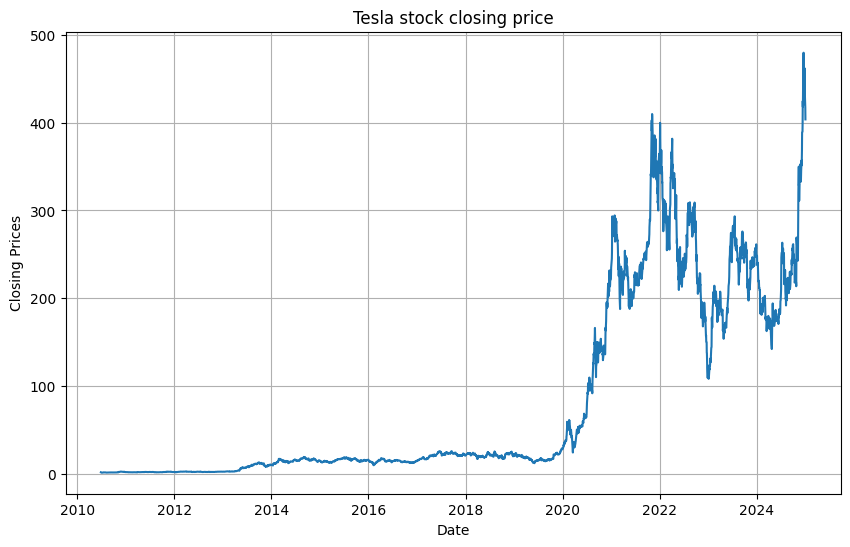

In [31]:
# Plot closing prices
df_close = stock_data['Close']

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(df_close)
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.title('Tesla stock closing price')

In [32]:
def test_stationarity(timeseries):
    '''
    Input: timeseries (dataframe): timeseries for which we want to study the stationarity
    '''

    #Determing rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',\
                                             '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

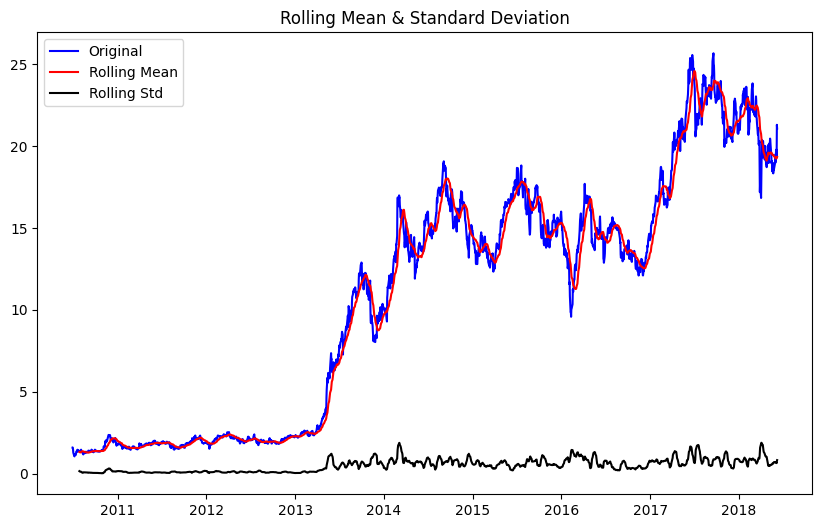

Results of Dickey-Fuller Test:
Test Statistic                   -0.936633
p-value                           0.775669
#Lags Used                        0.000000
Number of Observations Used    1999.000000
Critical Value (1%)              -3.433625
Critical Value (5%)              -2.862987
Critical Value (10%)             -2.567540
dtype: float64


In [33]:
plt.figure(figsize = (10,6))
test_stationarity(df_close.head(2000))

<Figure size 640x480 with 0 Axes>

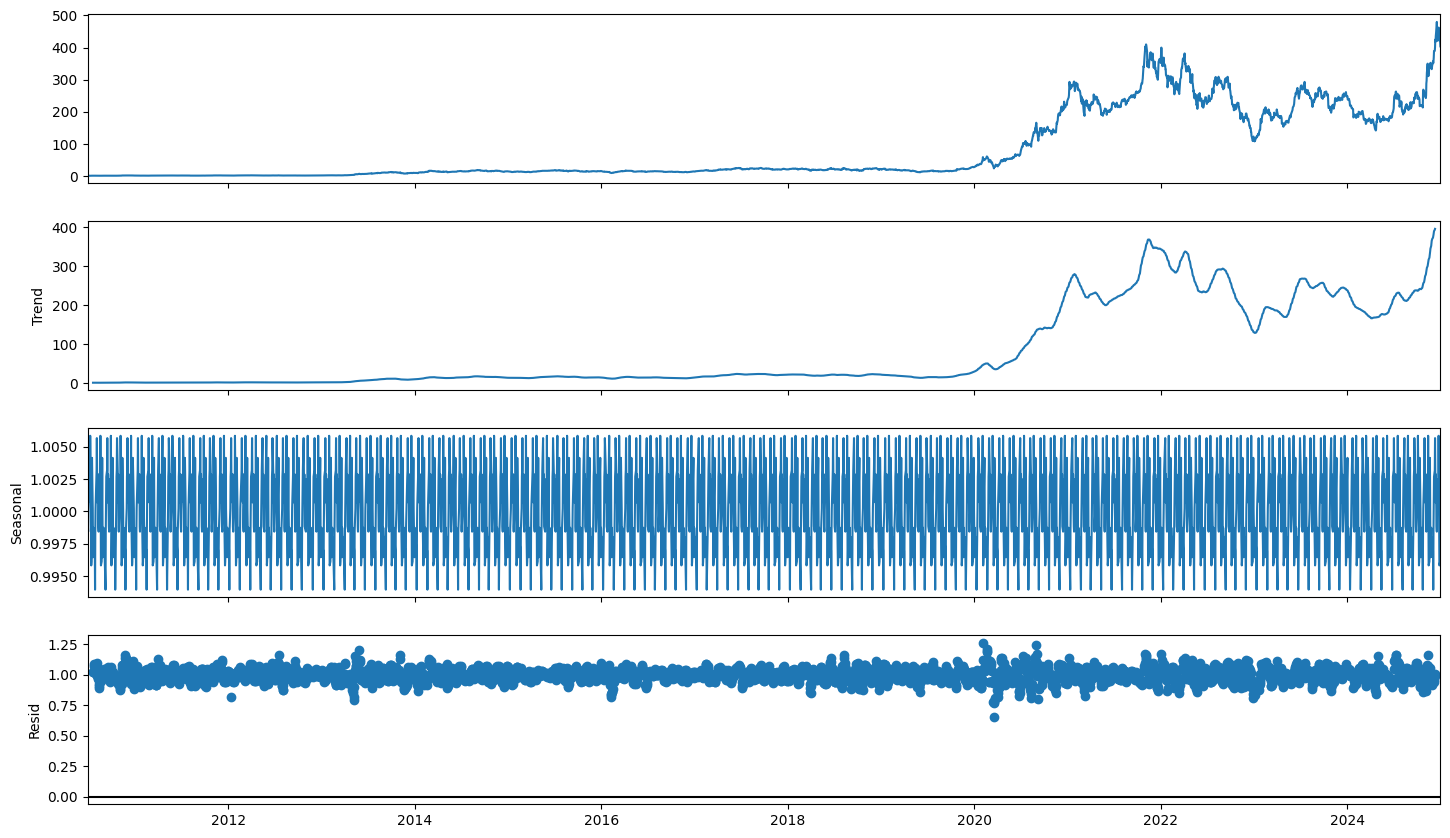

In [34]:

result = seasonal_decompose(df_close, model='multiplicative',period=28)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

 As the time series is constantly increasing, we apply a log transform, and a square root transform to flatten it.

Text(0.5, 1.0, 'Transformed data')

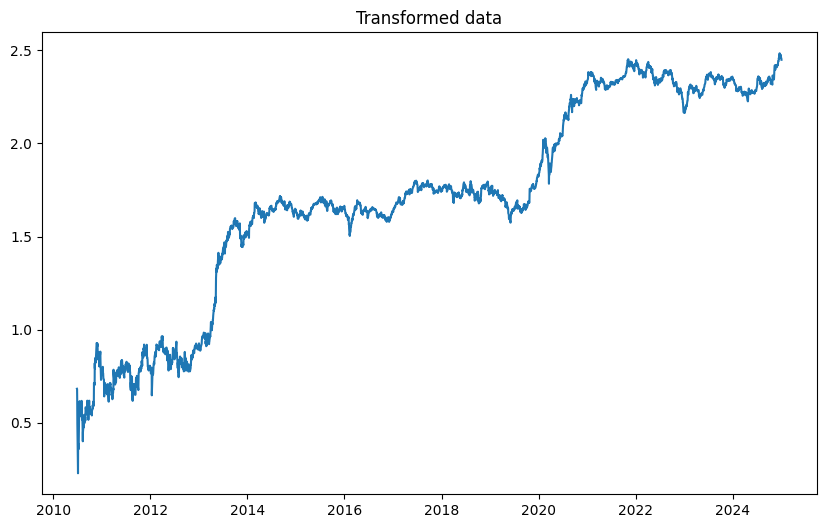

In [35]:
df_close_log = df_close.apply(np.log)
df_close_tf = df_close_log.apply(np.sqrt)

plt.figure(figsize = (10,6))
plt.plot(df_close_tf)
plt.title('Transformed data')

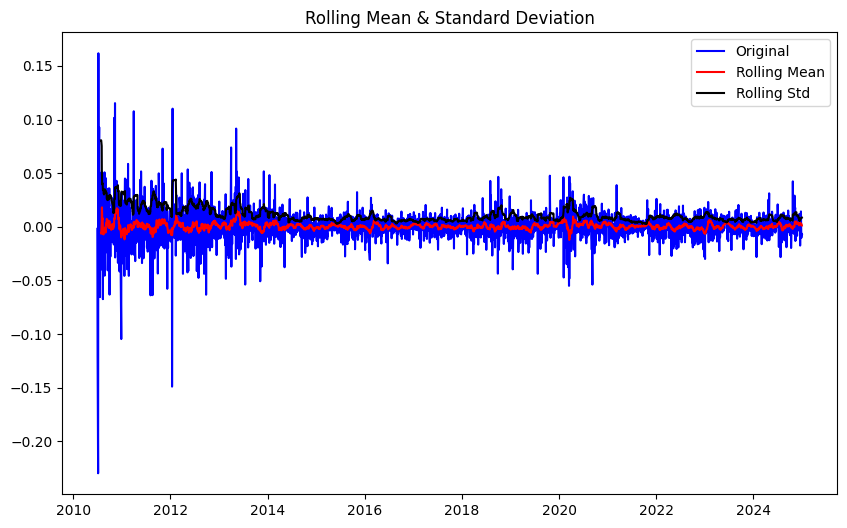

Results of Dickey-Fuller Test:
Test Statistic                  -36.904852
p-value                           0.000000
#Lags Used                        2.000000
Number of Observations Used    3648.000000
Critical Value (1%)              -3.432144
Critical Value (5%)              -2.862333
Critical Value (10%)             -2.567192
dtype: float64


In [36]:
df_close_shift = df_close_tf - df_close_tf.shift()

df_close_shift.dropna(inplace=True)
plt.figure(figsize = (10,6))
test_stationarity(df_close_shift)

##  LSTM <a class="anchor" id="chapter2"></a>


In [37]:
def preprocess_lstm(sequence, n_steps,n_features):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix >= len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)

    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))
    return X, y

In [38]:
# choose the number of days on which to base our predictions
nb_days = 60

n_features = 1

X, y = preprocess_lstm(df_close_shift.to_numpy(), nb_days, n_features)

###  Split Data (train set and test set) <a class="anchor" id="section_2_2"></a>

In [39]:
#Split the data set between the training set and the test set
test_days = 365

X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test = X[-test_days:], y[-test_days:]

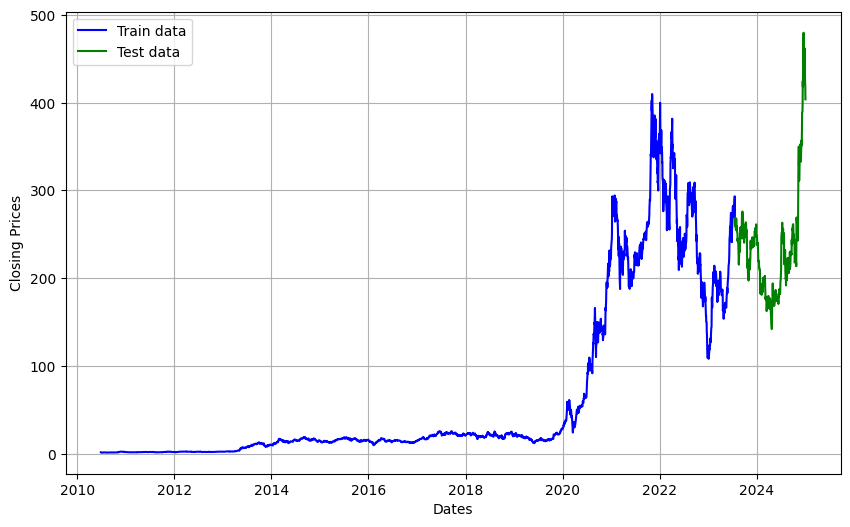

In [40]:
train_original = df_close.iloc[:-test_days]
test_original = df_close.iloc[-test_days:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.legend()

###  Implementing the model <a class="anchor" id="section_2_3"></a>



In [41]:
def vanilla_LSTM():
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(nb_days, n_features)))
    model.add(Dense(1))
    return model

In [42]:
model = vanilla_LSTM()
model.summary()
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

### Training and evaluating the model <a class="anchor" id="section_1_4"></a>

In [43]:
model.fit(X_train,
          y_train,
          epochs=15,
          batch_size = 32)

Epoch 1/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 1.8075e-04 - mean_absolute_error: 0.0091
Epoch 2/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.7059e-04 - mean_absolute_error: 0.0084
Epoch 3/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.8146e-04 - mean_absolute_error: 0.0086
Epoch 4/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.7633e-04 - mean_absolute_error: 0.0086
Epoch 5/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 1.7391e-04 - mean_absolute_error: 0.0083
Epoch 6/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.8357e-04 - mean_absolute_error: 0.0085
Epoch 7/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 1.7502e-04 - mean_absolute_error: 0.0084
Epoch 8/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.7333e-04 - mean_absolute_error: 0.0083
Epoch 9/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.7037e-04 - mean_absolute_error: 0.0086
Epoch 10/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 1.7806e-04 - mean_ab

In [44]:
# Evaluate the model on the test data using
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)
print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1283e-05 - mean_absolute_error: 0.0053
Test MSE: 6.221864168765023e-05
Test MAE: 0.005765363574028015


###  Predictions <a class="anchor" id="section_1_5"></a>



In [45]:
print(df_close_tf.shift().values.shape)


(3652, 1)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


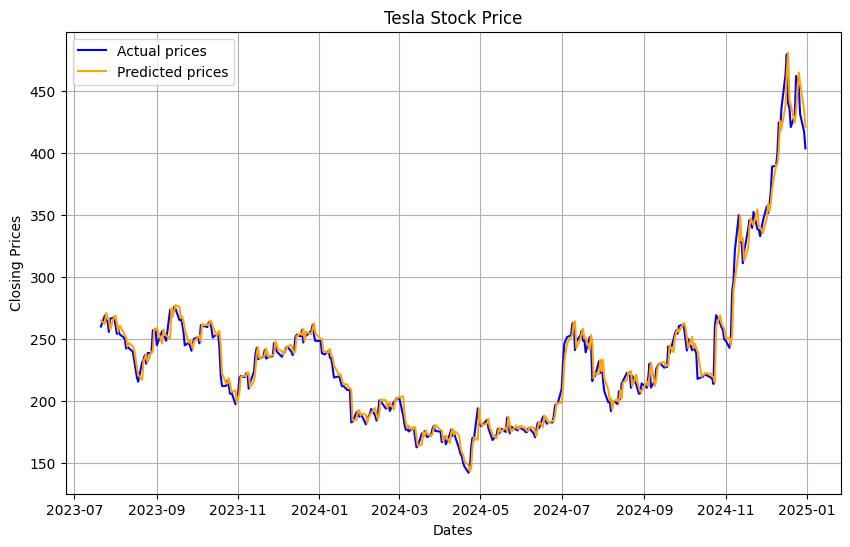

In [46]:
# Prediction
y_pred = model.predict(X_test)

# We create a dataframe from y_pred to have date-time indexes.
pred_data = pd.DataFrame(y_pred[:,0], test_original.index,columns=['Close'])

# Apply inverse transformation from 1.d

# Add the differenciation term
pred_data['Close'] = pred_data['Close'] + df_close_tf.shift().values[-test_days:].flatten()


# Take the square, and the exponent
pred_data = pred_data.apply(np.square)
pred_data = pred_data.apply(np.exp)


# Plot actual prices vs predicted prices
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_original,'b',label='Actual prices')
plt.plot(pred_data, 'orange',label='Predicted prices')
plt.title('Tesla Stock Price')

plt.legend()

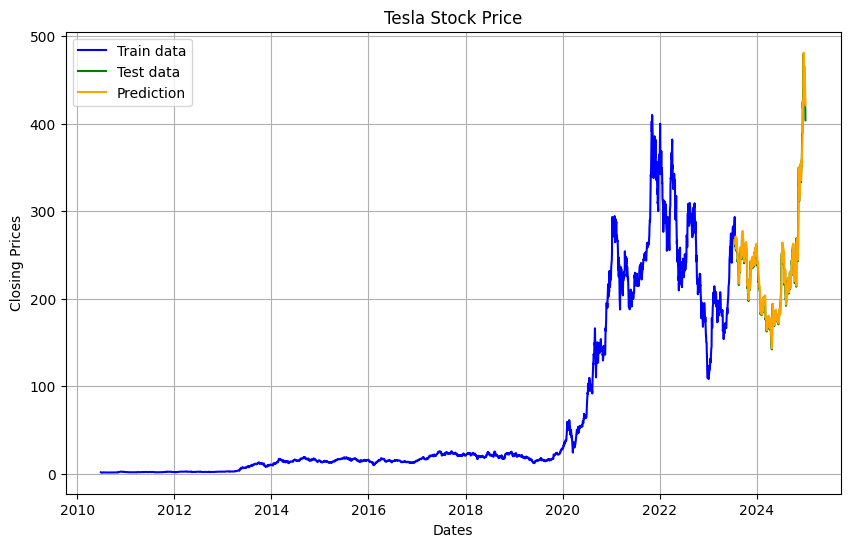

In [47]:

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.plot(pred_data, 'orange', label='Prediction')
plt.title('Tesla Stock Price')
plt.legend()